In [1]:
# for colab
!pip install albumentations -q
!pip install torchsummary -q
!pip install tqdm -q
!pip install pandas -q
!pip install kaggle -q

In [2]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle competitions download -c cs194-26-fall-2022-project-5
# !unzip cs194-26-fall-2022-project-5.zip

# I. Data Preprocessing

In [4]:
import xml.etree.ElementTree as ET
import numpy as np
import os

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']])

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark) # relative?

landmarks = np.array(landmarks).astype('float32')
bboxes = np.array(bboxes).astype('float32')

In [5]:
# build a dataset
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

import numpy
import cv2
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
class IbugTrainingHeatmapDataset(Dataset):
    def __init__(self, img_filenames, bboxes, landmarks, normalize=True, albu_transform=None, sigma=1):
        self.img_filenames = img_filenames
        self.bboxes = bboxes
        self.landmarks = landmarks
        self.albu_transform = albu_transform # albumentations
        self.normalize = normalize
        self.sigma = sigma
        if not self.normalize:
            print('Not normalizing the image')

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_path = self.img_filenames[idx]
        opened_img = Image.open(img_path).convert('RGB') # range [0, 255] # shape (H, W, C)
        bounding_box = self.bboxes[idx]
        landmark_ori = self.landmarks[idx] # (68, 2)

        x, y, w, h = bounding_box # left, top, width, height
        # some landmarks are out of the bounding box! how to deal with this?
        x_center = x + w / 2
        y_center = y + h / 2
        w1 = 1.3 * w
        h1 = 1.3 * h
        x = x_center - w1 / 2
        y = y_center - h1 / 2
        w = w1
        h = h1
        # x should be in [0, W], y should be in [0, H]
        x = max(0, x)
        y = max(0, y)
        x = min(x, opened_img.width - 1)
        y = min(y, opened_img.height - 1)
        w = min(w, opened_img.width - x)
        h = min(h, opened_img.height - y)

        cropped_by_bbox = opened_img.crop((x, y, x+w, y+h)) # shape (h, w, C)

        cropped_by_bbox = np.array(cropped_by_bbox) # range [0, 255] # shape (H, W, C)

        # to grayscale
        cropped_by_bbox = cv2.cvtColor(cropped_by_bbox, cv2.COLOR_RGB2GRAY) # shape (H, W)
        # resize
        cropped_by_bbox = cv2.resize(cropped_by_bbox, (224, 224))

        landmark = np.zeros_like(landmark_ori)
        landmark[:, 0] = landmark_ori[:, 0] - x
        landmark[:, 1] = landmark_ori[:, 1] - y
        landmark = landmark / [w, h] # relative coordinates

        # assert np.all(landmark == landmark2)
        # print("h: ", h, "w: ", w, "x: ", x, "y: ", y)

        # to relative coordinates
        if self.albu_transform:
            transformed = self.albu_transform(image=cropped_by_bbox, keypoints=landmark * 224)
            tfed_im = transformed['image'] # 68 tokens and each token has 224*224 classes
            landmark = transformed['keypoints'] / 224.
        else:
            tfed_im = cropped_by_bbox

        if self.normalize:
            tfed_im = tfed_im / 255.0 - 0.5

        # heatmap should be (68, 224, 224)
        heatmap = self._gaussian_heatmap(landmark * 224, 224, 224, 68)
        heatmap = torch.tensor(heatmap)
        heatmap = heatmap.float()
        landmark = torch.tensor(landmark)
        return tfed_im, heatmap, landmark # tfed_im: (C=1, 224, 224), heatmap: (68, 224, 224), landmark: (68, 2)

    def _gaussian_heatmap(self, landmark, height, width, channels):
        heatmap = np.ones((channels, height, width)).astype(np.float32)
        # landmark: (68, 2)
        for i, (x, y) in enumerate(landmark):
            x_coords = np.arange(width) # from 0 to width-1
            y_coords = np.arange(height) # 68 tokens and each token has 224*224 classes
            x_coords, y_coords = np.meshgrid(x_coords, y_coords)
            heatmap[i] = np.exp(-((x_coords / 224. - x / 224.) ** 2 + (y_coords / 224. - y / 224.) ** 2) / (2 * self.sigma ** 2))
            # print("x: ", x, "y: ", y)
            # print("heatmap: ", heatmap[i])
            # optional: normalize the heatmap by max or sum
            heatmap[i] = heatmap[i] / np.sum(heatmap[i])
        return heatmap

transform = A.Compose([
    A.Affine(rotate=(-15, 15), translate_percent={'x': 0.1, 'y': 0.1}),
    A.GaussNoise(p=0.5), # DO WE NEED THIS?
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

dataset = IbugTrainingHeatmapDataset(img_filenames, bboxes, landmarks, albu_transform=transform, normalize=True, sigma=.1)

In [7]:
from unet import heatmap_to_landmarks

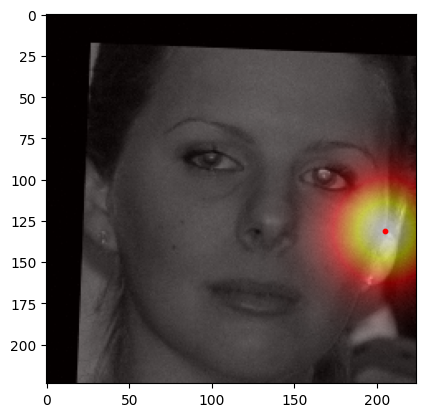

tensor([205.4998, 131.4999])
tensor([205.1779, 131.2815])
ABS MAE: 0.2701568603515625


In [8]:
# visualize one heatmap
import matplotlib.pyplot as plt
tfed_im, heatmap, landmark = dataset[515]
# print(tfed_im)
plt.imshow(tfed_im.permute(1, 2, 0).squeeze(), cmap='gray')
# show heatmap
ii = 15
plt.imshow(heatmap[ii], cmap='hot', alpha=0.5)
# show landmark
plt.scatter(landmark[ii, 0] * 224, landmark[ii, 1] * 224, s=10, c='red')
plt.show()
# want to aggregate the heatmap to get the landmark
landmark_gt = heatmap_to_landmarks(heatmap.unsqueeze(0)).squeeze(0)
print(landmark_gt[ii])
print(landmark[ii] * 224)
print("ABS MAE:", (landmark_gt[ii] - landmark[ii] * 224).abs().mean().item())

# II. Model Architecture
We use a UNet predicting the probability density heatmap (shape [68, 224, 224]) of the face landmarks, and then find the expected position of the landmarks w.r.t. the heatmap,
i.e. a pixelwise classification problem.

In [9]:
# unet
import torch
import torch.nn as nn
import torch.nn.functional as F
# load unet
from unet import PixelwiseClassificationUNet

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PixelwiseClassificationUNet(1, 68, 128).to(device)
def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)
model.apply(init_weights)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {n_params}')

Number of parameters: 7603012


# III. Training

In [11]:

from tqdm import tqdm
LR = 5e-3
BS = 16
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
num_epochs = 30
criterion = nn.MSELoss(reduction='sum')
# criterion = nn.BCEWithLogitsLoss()
mae = nn.L1Loss()
# criterion = nn.BCEWithLogitsLoss() # recommended for binary classification i.e. label is 0 or 1
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)])
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=128)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=128)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
from unet import heatmap_to_landmarks

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# train
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_mae = 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
    for i, (images, heatmaps, landmark) in loop:
        # bad heatmap -> jump to next iteration
        # i.e. < 1e-4
        # if torch.sum(heatmaps) < 1e-4:
        #     continue
        images = images.to(device) # shape: (B, C, H, W)
        landmark = landmark.to(device) # shape: (B, 68, 2)
        heatmaps = heatmaps.to(device) # shape: (B, 68, H, W)

        # Forward pass
        logits = model.forward(images, return_heatmap=True) # shape: (B, 68, 224*224)
        probs = F.softmax(logits, dim=2) # shape: (B, 68, 224*224)
        # probs = F.sigmoid(logits)
        probs = probs.view(-1, 68, 224, 224)
        loss = criterion(probs, heatmaps)

        # loss = criterion(logits, heatmaps.view(-1, 68, 224*224)) # BCE with logits

        # learn the heatmap: not what we are doing now
        # pred_heatmap = model(images, return_heatmap=True) # shape: (B, 68, H*W)
        # do BCE
        # heatmaps = heatmaps.view(-1, 68, 224*224) # shape: (B, 68, H*W)
        # loss = bce(pred_heatmap, heatmaps)
        with torch.no_grad():
            predicted_landmark = heatmap_to_landmarks(probs) # shape: (B, 68, 2)
            # tqdm.write("Predicted [0][0]: ", predicted_landmark[0][0])
            # tqdm.write("Groundtruth [0][0]: ",landmark[0][0] * 224)
            mae_loss = mae(predicted_landmark / 224, landmark) * 224
            train_mae += mae_loss.item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(train_loss=loss.item(), train_mae=mae_loss.item())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_mae /= len(train_loader)
    # validation
    model.eval()
    val_loss = 0
    val_mae = 0
    val_probs_to_plot = None
    loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=True)
    loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
    with torch.no_grad():
        for i, (images, heatmaps, landmark) in loop:
            images = images.to(device)
            heatmaps = heatmaps.to(device)
            landmark = landmark.to(device)
            logits = model.forward(images, return_heatmap=True) # (B, 68, 224*224)
            probs = F.sigmoid(logits)
            probs = probs.view(-1, 68, 224, 224)

            predicted_landmark = heatmap_to_landmarks(probs)
            loss = criterion(probs, heatmaps)
            mae_loss = mae(predicted_landmark / 224, landmark) * 224

            val_loss += loss.item()
            val_mae += mae_loss.item()
            loop.set_postfix(val_loss=loss.item(), val_mae=mae_loss.item())

            # 假设我们只plot第一组验证数据的heatmap
            if val_probs_to_plot is None:
                val_probs_to_plot = probs[0].detach().cpu().numpy()  # 取 batch 中第一个样本

    val_loss /= len(val_loader)
    val_mae /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train MAE: {train_mae}, Val MAE: {val_mae}')

    # 在每个epoch结束后进行plot
    if val_probs_to_plot is not None:
        # val_probs_to_plot shape: (68, 224, 224)
        # 我们可以任选一个关键点的heatmap来进行展示，例如第0个关键点:
        plt.figure(figsize=(6,6))
        plt.title(f'Epoch {epoch+1} - Predicted Heatmap for Landmark 0')
        plt.imshow(val_probs_to_plot[0], cmap='hot')
        plt.colorbar()
        plt.show()

        # 如果想将所有关键点的heatmap求和叠加展示(形成整体的关键点关注区域):
        summed_heatmap = val_probs_to_plot.sum(axis=0)  # shape: (224, 224)
        plt.figure(figsize=(6,6))
        plt.title(f'Epoch {epoch+1} - Summed Predicted Heatmap')
        plt.imshow(summed_heatmap, cmap='hot')
        plt.colorbar()
        plt.show()


Epoch [1/30]:   0%|          | 0/375 [00:00<?, ?it/s]

In [ ]:


# %pip install pandas
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import os

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test_parsed.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']])

bboxes = np.array(bboxes).astype('float32')
print(bboxes.shape)
print(len(img_filenames))
print(img_filenames[0])

# we now have img_filenames and bboxes
# for every i in range(len(img_filenames)),
# we crop the image, resize it to (224, 224), and then feed it to the model
# the output is the landmarks in shape (68, 2)
class IBugTestDataset(Dataset):
    def __init__(self, img_filenames, bboxes, normalize=True, basic_transform=None):
        self.img_filenames = img_filenames
        self.bboxes = bboxes
        self.basic_transform = basic_transform # resize, totensor
        self.normalize = normalize

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_path = self.img_filenames[idx]
        # grayscale
        opened_img = Image.open(img_path).convert('RGB') # range [0, 255] # shape (H, W, C)
        bounding_box = self.bboxes[idx]
        x, y, w, h = bounding_box # left, top, width, height
        cropped_by_bbox = opened_img.crop((x, y, x+w, y+h))
        cropped_by_bbox = np.array(cropped_by_bbox) # range [0, 255]
        if self.normalize:
            cropped_by_bbox = cropped_by_bbox / 255.0 - 0.5

        if self.basic_transform:
            cropped_by_bbox = self.basic_transform(cropped_by_bbox)
        else:
            cropped_by_bbox = torch.tensor(cropped_by_bbox).permute(2, 0, 1) # (C, H, W)
        return cropped_by_bbox, bounding_box

basic_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # From (C, H, W) to (C, 224, 224)
    # grayscale
    transforms.Grayscale(num_output_channels=1), # From (C, H, W) to (1, H, W)
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = IBugTestDataset(img_filenames, bboxes, basic_transform=basic_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=False)

# test
model.eval()
preds = []
with torch.no_grad():
    for (images, bbox) in tqdm(test_loader):
        images = images.to(device)
        logits = model(images) # [0, 1] # shape: (B, 68, 224*224)
        probs = F.sigmoid(logits) # shape: (B, 68, 224*224)
        probs = probs.view(-1, 68, 224, 224)
        predicted_landmarks = heatmap_to_landmarks(probs) # shape: (B, 68, 2)
        x, y, w, h = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
        # to devices
        x, y, w, h = x.to(device), y.to(device), w.to(device), h.to(device)
        # adjust the landmark
        predicted_landmarks[:, :, 0] = predicted_landmarks[:, :, 0] * w[:, None] + x[:, None]
        predicted_landmarks[:, :, 1] = predicted_landmarks[:, :, 1] * h[:, None] + y[:, None]
        preds.append(predicted_landmarks)
preds = torch.cat(preds, dim=0) # (N, 68, 2)
# preds = preds.cpu().numpy()
# preds = preds.tolist()



In [ ]:
alternating_names = [] # should be 136 * test_size(1008) = 137088
alternating_values = []
counter = 0
for i in range(len(preds)):
    pred = preds[i] # (68, 2)
    # to list
    pred = pred.cpu().numpy().tolist()

    for j in range(68):
        # alternating_names.append(f'image_{i+1}_keypoints_{j+1}_x')
        alternating_names.append(str(counter))
        counter += 1
        alternating_names.append(str(counter))
        counter += 1
        # alternating_names.append(f'image_{i+1}_keypoints_{j+1}_y')

        alternating_values.append(pred[j][0]) # x
        alternating_values.append(pred[j][1]) # y



df = pd.DataFrame({'Id': alternating_names, 'Predicted': alternating_values})

os.makedirs('4', exist_ok=True)
df.to_csv('4/submission.csv', index=False)
!cd 4 && ls -l && kaggle competitions submit -c cs194-26-fall-2022-project-5 -f submission.csv -m "UNet, 30 epochs, 1e-3 LR, 16 BS, 64 hidden channels"
